In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.graphics.tsaplots import plot_acf
import  matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.tree import DecisionTreeClassifier


In [57]:
df = pd.read_csv("../BTC_1_year_data_15m.csv").set_index("close_time")
df

,open,high,low,close,volume,open_time,taker_buy_base
close_time,,,,,,,
2024-12-02 12:44:59.999000+00:00,95386.14,95407.64,95080.85,95080.86,299.14374,2024-12-02 12:30:00+00:00,110.43173
2024-12-02 12:59:59.999000+00:00,95080.85,95087.98,94766.00,94972.02,352.27560,2024-12-02 12:45:00+00:00,139.92863
2024-12-02 13:14:59.999000+00:00,94972.03,95490.37,94837.77,95399.83,389.06173,2024-12-02 13:00:00+00:00,213.37077
2024-12-02 13:29:59.999000+00:00,95399.84,95743.66,95397.31,95690.65,478.14614,2024-12-02 13:15:00+00:00,272.74969
2024-12-02 13:44:59.999000+00:00,95690.64,95822.61,95567.44,95577.74,445.23818,2024-12-02 13:30:00+00:00,222.18680
...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,87084.00,87419.99,86993.27,87419.99,239.49429,2025-12-02 11:15:00+00:00,145.59817
2025-12-02 11:44:59.999000+00:00,87419.99,87458.67,87320.01,87329.60,223.03098,2025-12-02 11:30:00+00:00,140.45822
2025-12-02 11:59:59.999000+00:00,87329.60,87602.47,87326.85,87368.92,146.36004,2025-12-02 11:45:00+00:00,93.61402


#### Feature Engineering

In [58]:
df["close_log_return"] = np.log(df["close"]/df["close"].shift())
df["volume_change"] = df["volume"].pct_change().shift()

    Create lagged features

In [59]:
df = df.copy()

In [60]:
def generate_ma_features(df, close_col="close", windows=[5, 10], shift_pct=True):
    """
    Generate moving average and pct-change-to-close features for a list of window sizes.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with at least a 'close' column.
    close_col : str
        Column name for the close price.
    windows : list
        List of integers for rolling windows.
    shift_pct : bool
        Whether to shift pct-change features by 1 step to avoid leakage.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with new features added.
    """
    df = df.copy()

    for w in windows:
        ma_col = f"{w}ma"
        pct_col = f"pct_change_{w}ma_close"

        # Moving average
        df[ma_col] = df[close_col].rolling(w).mean()

        # Percentage difference from MA
        df[pct_col] = (df[close_col] - df[ma_col]) / df[ma_col] * 100

        # Shift to avoid leakage (optional)
        if shift_pct:
            df[pct_col] = df[pct_col].shift()

    return df


windows = [10, 50,200]

df = generate_ma_features(df, windows=windows)


In [61]:
df["close_log_return_lag_1"] = df["close_log_return"].shift()
df["close_log_return_lag_2"] = df["close_log_return"].shift(2)
df["close_log_return_lag_3"] = df["close_log_return"].shift(3)

In [62]:
df["sell_volume"] = df["volume"] - df["taker_buy_base"]

df["buy_sell_pressure"] = (df["taker_buy_base"] - df["sell_volume"]) / df["volume"]
df["buy_sell_pressure_lag1"] = df["buy_sell_pressure"].shift(1)


In [63]:
df = df.dropna(how="any")

    Create binary classification target
        - 1=> Long => Price moves up
        - 0=> Short => Price goes down

In [64]:
df["close_log_return_dir"] = df["close_log_return"].map(lambda x:1 if x>0 else 0)
# df = df.drop(columns="close_log_return")

In [65]:
df

,open,high,low,close,volume,open_time,taker_buy_base,close_log_return,volume_change,10ma,...,pct_change_50ma_close,200ma,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure,buy_sell_pressure_lag1,close_log_return_dir
close_time,,,,,,,,,,,,,,,,,,,,,
2024-12-04 14:44:59.999000+00:00,95780.68,96560.00,95693.05,96349.20,804.71847,2024-12-04 14:30:00+00:00,457.08398,0.005918,-0.329977,95828.210,...,-0.449413,95782.00485,0.005238,0.002851,-0.001648,-0.000026,347.63449,0.136010,0.044281,1
2024-12-04 14:59:59.999000+00:00,96349.20,96377.54,95784.26,95822.99,869.22756,2024-12-04 14:45:00+00:00,418.40142,-0.005476,1.516310,95820.033,...,0.121562,95786.25970,0.592173,0.005918,0.002851,-0.001648,450.82614,-0.037303,0.136010,0
2024-12-04 15:14:59.999000+00:00,95822.99,96386.20,95411.47,96044.01,936.07367,2024-12-04 15:00:00+00:00,506.36306,0.002304,0.080164,95835.668,...,-0.429668,95789.48060,0.038346,-0.005476,0.005918,0.002851,429.71061,0.081887,-0.037303,1
2024-12-04 15:29:59.999000+00:00,96044.01,96212.87,95807.47,96094.73,552.00969,2024-12-04 15:15:00+00:00,251.54963,0.000528,0.076903,95848.343,...,-0.209072,95791.50100,0.265717,0.002304,-0.005476,0.005918,300.46006,-0.088604,0.081887,1
2024-12-04 15:44:59.999000+00:00,96094.74,96154.52,95738.53,95928.03,839.80304,2024-12-04 15:30:00+00:00,390.85216,-0.001736,-0.410292,95850.825,...,-0.162737,95793.25245,0.316551,0.000528,0.002304,-0.005476,448.95088,-0.069181,-0.088604,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,87084.00,87419.99,86993.27,87419.99,239.49429,2025-12-02 11:15:00+00:00,145.59817,0.003851,-0.329264,86950.001,...,0.367559,87780.97745,-0.816609,-0.002162,0.002398,0.003057,93.89612,0.215880,-0.127475,1
2025-12-02 11:44:59.999000+00:00,87419.99,87458.67,87320.01,87329.60,223.03098,2025-12-02 11:30:00+00:00,140.45822,-0.001035,0.007008,87017.394,...,0.735136,87760.53735,-0.411237,0.003851,-0.002162,0.002398,82.57276,0.259540,0.215880,0
2025-12-02 11:59:59.999000+00:00,87329.60,87602.47,87326.85,87368.92,146.36004,2025-12-02 11:45:00+00:00,93.61402,0.000450,-0.068742,87067.010,...,0.610582,87740.31660,-0.491038,-0.001035,0.003851,-0.002162,52.74602,0.279229,0.259540,1


In [66]:
df_temp = pd.DataFrame(columns=["close_log_return", "close"])
df_temp[["close_log_return", "close"]] = df[["close_log_return", "close"]]

In [67]:
def drop_ma_columns(df, windows, extra_drop=None):
    """
    Remove moving-average columns after pct-change features are created.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    windows : list
        List of MA windows used (e.g., [5,10,20]).
    extra_drop : list or None
        Additional columns to drop explicitly.

    Returns
    -------
    df : pd.DataFrame
        DataFrame with MA columns removed.
    """
    df = df.copy()

    # ma columns generated earlier
    ma_cols = [f"{w}ma" for w in windows]

    # combine with user-provided columns
    if extra_drop:
        drop_cols = list(set(ma_cols + extra_drop))
    else:
        drop_cols = ma_cols

    # drop only those that actually exist
    drop_cols = [c for c in drop_cols if c in df.columns]

    df = df.drop(columns=drop_cols, errors="ignore")

    return df


df = drop_ma_columns(
    df,
    windows,
    extra_drop=["volume", "close_log_return", "open", "high", "low", "close", 'buy_sell_pressure',"taker_buy_base","open_time"],
)

In [68]:
def plot_feature_scatter(df, sample_size=2000):
    """
    Creates a scatter plot matrix (pairplot) for all features in df.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing numerical features.
    sample_size : int
        Optional sampling to speed up plotting (very important for large datasets).
    """
    
    # Use only numeric columns
    numeric_df = df.select_dtypes(include=["number"]).copy()

    # Optional sampling for speed
    if len(numeric_df) > sample_size:
        numeric_df = numeric_df.sample(sample_size, random_state=42)

    sns.pairplot(numeric_df, diag_kind="kde")
    plt.show()


In [69]:
# plot_feature_scatter(df)

In [70]:
df.head()

,volume_change,pct_change_10ma_close,pct_change_50ma_close,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure_lag1,close_log_return_dir
close_time,,,,,,,,,,
2024-12-04 14:44:59.999000+00:00,-0.329977,-0.014294,-0.449413,0.005238,0.002851,-0.001648,-0.000026,347.63449,0.044281,1
2024-12-04 14:59:59.999000+00:00,1.516310,0.543671,0.121562,0.592173,0.005918,0.002851,-0.001648,450.82614,0.136010,0
2024-12-04 15:14:59.999000+00:00,0.080164,0.003086,-0.429668,0.038346,-0.005476,0.005918,0.002851,429.71061,-0.037303,1
2024-12-04 15:29:59.999000+00:00,0.076903,0.217395,-0.209072,0.265717,0.002304,-0.005476,0.005918,300.46006,0.081887,1
2024-12-04 15:44:59.999000+00:00,-0.410292,0.257059,-0.162737,0.316551,0.000528,0.002304,-0.005476,448.95088,-0.088604,0


    Check class imbalance

In [71]:
print(df["close_log_return_dir"].value_counts())

close_log_return_dir
0    17461
1    17379
Name: count, dtype: int64


#### Split data into training and testing set but in temporal order

    Feature-Target Split

In [72]:
X = df.iloc[:,:-1 ]
y = df.iloc[:,-1]

In [73]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.4, shuffle=False)
X_val, X_test, y_val, y_test=train_test_split(X_test,y_test, test_size=0.2, shuffle=False)

In [74]:
df_temp["close_log_return"]

close_time
2024-12-04 14:44:59.999000+00:00    0.005918
2024-12-04 14:59:59.999000+00:00   -0.005476
2024-12-04 15:14:59.999000+00:00    0.002304
2024-12-04 15:29:59.999000+00:00    0.000528
2024-12-04 15:44:59.999000+00:00   -0.001736
                                      ...   
2025-12-02 11:29:59.999000+00:00    0.003851
2025-12-02 11:44:59.999000+00:00   -0.001035
2025-12-02 11:59:59.999000+00:00    0.000450
2025-12-02 12:14:59.999000+00:00    0.000909
2025-12-02 12:29:59.999000+00:00   -0.000844
Name: close_log_return, Length: 34840, dtype: float64

In [75]:
def time_split(x, train_size=0.8):
    i = int(len(x) * train_size)
    return x[:i].copy(), x[i:].copy()


df_train_temp, df_test_temp = time_split(df_temp, train_size=0.6)

In [76]:
print(y_train.value_counts())
print(y_test.value_counts())

close_log_return_dir
0    10475
1    10429
Name: count, dtype: int64
close_log_return_dir
0    1411
1    1377
Name: count, dtype: int64


### Scikit-learn Cecision Tree Model

In [77]:
model = DecisionTreeClassifier(max_depth=7)

In [78]:
model.fit(X_train,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [79]:
accuracy_score(y_train, model.predict(X_train))

0.6049081515499426

In [80]:
accuracy_score(y_test, model.predict(X_test))


0.5778335724533716

In [81]:
cm = confusion_matrix(y_test, model.predict(X_test))

#### Hyperparameter Tuning

In [82]:
depth_hyperparams = range(1,50,2)

In [83]:
training_acc =  []
validation_acc = []
for d in depth_hyperparams:
    # Create model with `max_depth` of `d`
    test_model = DecisionTreeClassifier(random_state=42, max_depth=d)
        
    #Fit model to the training data
    test_model.fit(X_train, y_train)
    #Calculate training accuracy score and append to `training_acc`
    training_acc.append(test_model.score(X_train,y_train))
    #Calculate validation accuracy score and append to `validation_acc`
    validation_acc.append(test_model.score(X_val,y_val))

    print("Training Accuracy Scores:", training_acc[:3])
    print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.5542001530807501]
Validation Accuracy Scores: [0.56243272335845]
Training Accuracy Scores: [0.5542001530807501, 0.5696995790279372]
Validation Accuracy Scores: [0.56243272335845, 0.5688015787585217]
Training Accuracy Scores: [0.5542001530807501, 0.5696995790279372, 0.585390355912744]
Validation Accuracy Scores: [0.56243272335845, 0.5688015787585217, 0.5756189451022605]
Training Accuracy Scores: [0.5542001530807501, 0.5696995790279372, 0.585390355912744]
Validation Accuracy Scores: [0.56243272335845, 0.5688015787585217, 0.5756189451022605]
Training Accuracy Scores: [0.5542001530807501, 0.5696995790279372, 0.585390355912744]
Validation Accuracy Scores: [0.56243272335845, 0.5688015787585217, 0.5756189451022605]
Training Accuracy Scores: [0.5542001530807501, 0.5696995790279372, 0.585390355912744]
Validation Accuracy Scores: [0.56243272335845, 0.5688015787585217, 0.5756189451022605]
Training Accuracy Scores: [0.5542001530807501, 0.5696995790279372, 0.58539035591

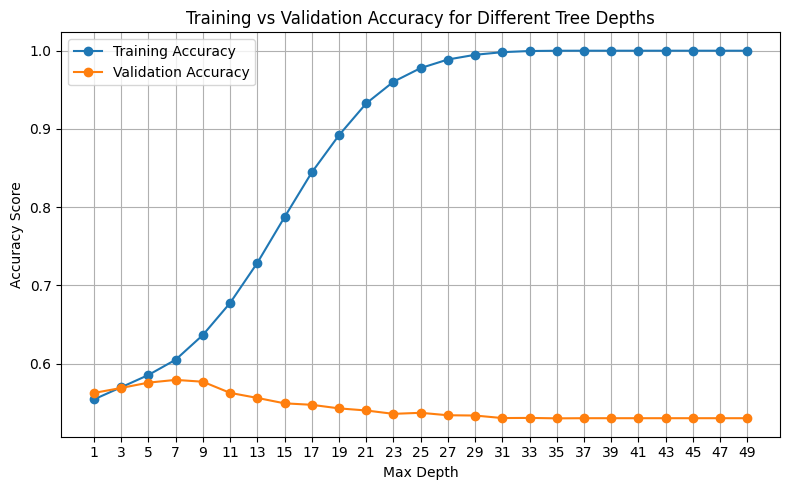

In [84]:
plt.figure(figsize=(8,5))

plt.plot(depth_hyperparams, training_acc, marker='o', label="Training Accuracy")
plt.plot(depth_hyperparams, validation_acc, marker='o', label="Validation Accuracy")


plt.xticks(depth_hyperparams)

plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Training vs Validation Accuracy for Different Tree Depths")

plt.grid(True)  # Add grid
plt.legend()
plt.tight_layout()
plt.show()


<p style="color: yellow">TP, FP, TN, FN are purely relative to whatever you declare as the positive class.</p>

    - 1 is UP prediction
    - 0 is DOWN prediction
    - 1 is positive class
    - 0 is negative class



In [85]:
TN = cm[0][0]   #True Down  - When it should be down and model predicted down
FN = cm[1][0]   #False down - When it should be up but the model predicted down
FP = cm[0][1]   #False up   - When it should be down but the model predicted up
TP = cm[1][1]   #True UP    - When it should be up and the model predicted up

In [86]:
print(TN), print(TP), print(FN), print(FN)

1025
586
791
791


(None, None, None, None)

#### Evaluate win rate

    Accuracy Measure

In [87]:
(TP+TN)/(TP+TN+FP+FN) 

np.float64(0.5778335724533716)

#### Evaluate the up Predictibility

In [88]:
TP/(TP+FP)

np.float64(0.602880658436214)

#### Evaluate the up Predictibility

<p style="color: yellow; font-size: 20px">Recall</p>
    


In [89]:
TP/(TP+FN)  # Here we are essentially looking at - from all the True classes, how many True classes I predicted correctly

np.float64(0.42556281771968046)

<p style="color: yellow; font-size: 20px">Precision</p>

Precision is, for all of my predictions for a particular class, how many times I was right


In [90]:
TP/(TP+FP) # From all the times I predicted True/UP, How many were actually true/up

np.float64(0.602880658436214)

#### Evaluate down predictability

<p style="color: yellow; font-size: 20px">Recall</p>


In [91]:
TN / (TN+FP) # Here we are essentially looking at - from all the False classes, how many false classes I predicted correctly

np.float64(0.7264351523742026)

<p style="color: yellow; font-size: 20px">Precision</p>


In [92]:
TN / (TN+FN)    # From as many times I predicted false, how many were actually false.

np.float64(0.5644273127753304)

###### **PRECISION**
###### "When I predict UP, how often am I actually right?"

```python
Precision = TP / (TP + FP)
```

**Out of all my UP predictions, how many were actually correct?**

- **Focus:** My predicted UP events (my actions)
- **Fear:** False Positives (wrongly predicting UP when it's actually DOWN)
- **High precision = When I say UP, you can trust me — but I might be missing opportunities**

---

###### **RECALL**
###### "How many actual UP moves did I successfully catch?"

```python
Recall = TP / (TP + FN)
```

**Out of all the real UP days, how many did my model correctly predict as UP?**

- **Focus:** The actual UP events (reality)
- **Fear:** False Negatives (missing UP days)
- **High recall = I catch most of the UP moves, even if I sometimes make wrong predictions**

---

###### **The Key Difference**

| | Precision | Recall |
|---|-----------|--------|
| **Perspective** | YOUR predictions | REALITY's events |
| **Denominator** | What YOU predicted | What ACTUALLY happened |
| **Question** | "Am I accurate?" | "Am I thorough?" |
| **Trading analogy** | "Hit rate of my signals" | "% of opportunities captured" |

---

###### **Trading Strategy Examples**

###### **High Precision, Low Recall Strategy**
- Very selective, only trades slam-dunk setups
- Few trades, but most are winners
- Good for: High transaction costs, limited capital, risk-averse

###### **Low Precision, High Recall Strategy**
- Casts a wide net, takes many signals
- Catches most moves, but many false alarms
- Good for: Low transaction costs, diversification, systematic execution

###### **Balanced Strategy**
- Optimizes F1-score (harmonic mean of precision and recall)
- Trades off some accuracy for better coverage
- Good for: Most real-world trading applications

---

###### **The Trade-off**

You can't maximize both simultaneously:

- ↑ Threshold → ↑ Precision, ↓ Recall (be picky)
- ↓ Threshold → ↓ Precision, ↑ Recall (be aggressive)

**The optimal balance depends on your strategy's economics.**


#### Directional Balance : Short Ratio

In [93]:
short_ratio = (FN+TN)/(FN+TN+FP+FP)
short_ratio

np.float64(0.7017001545595054)

#### Directional Balance: Long Ratio

In [94]:
long_ratio = (FP+TP)/(FN+TN+FP+FP)
long_ratio

np.float64(0.3755795981452859)

#### Directional Imbalance

In [95]:
short_ratio/long_ratio

np.float64(1.8683127572016462)

#### Evaluating Model's profitabilty (Out-of-sample)

In [96]:
df_test = X_test.copy()

In [97]:
df_test

,volume_change,pct_change_10ma_close,pct_change_50ma_close,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure_lag1
close_time,,,,,,,,,
2025-11-03 11:44:59.999000+00:00,-0.546168,0.203221,-0.642202,-1.949862,0.001021,0.005150,-0.002531,45.93872,-0.059760
2025-11-03 11:59:59.999000+00:00,-0.415796,0.299136,-0.501981,-1.850813,0.000906,0.001021,0.005150,46.62227,0.080222
2025-11-03 12:14:59.999000+00:00,0.265119,0.309196,-0.409183,-1.792970,0.000489,0.000906,0.001021,110.45926,0.262153
2025-11-03 12:29:59.999000+00:00,1.313366,0.500531,-0.108585,-1.531087,0.002580,0.000489,0.000906,71.39557,0.244333
2025-11-03 12:44:59.999000+00:00,-0.345603,0.577465,0.108450,-1.350965,0.001748,0.002580,0.000489,86.47439,0.253623
...,...,...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,-0.329264,0.263426,0.367559,-0.816609,-0.002162,0.002398,0.003057,93.89612,-0.127475
2025-12-02 11:44:59.999000+00:00,0.007008,0.540528,0.735136,-0.411237,0.003851,-0.002162,0.002398,82.57276,0.215880
2025-12-02 11:59:59.999000+00:00,-0.068742,0.358786,0.610582,-0.491038,-0.001035,0.003851,-0.002162,52.74602,0.259540


In [98]:
model.predict(X_test)

array([1, 1, 0, ..., 1, 1, 0], shape=(2788,))

In [99]:
model.predict_proba(X_test)

array([[0.40914286, 0.59085714],
       [0.40914286, 0.59085714],
       [0.52601156, 0.47398844],
       ...,
       [0.28571429, 0.71428571],
       [0.46892655, 0.53107345],
       [0.53557312, 0.46442688]], shape=(2788, 2))

In [100]:
df_test["y_pred_binary"] = model.predict(X_test)
df_test[["close_log_return", "close"]] = df_test_temp[["close_log_return", "close"]]

In [101]:
df_test

,volume_change,pct_change_10ma_close,pct_change_50ma_close,pct_change_200ma_close,close_log_return_lag_1,close_log_return_lag_2,close_log_return_lag_3,sell_volume,buy_sell_pressure_lag1,y_pred_binary,close_log_return,close
close_time,,,,,,,,,,,,
2025-11-03 11:44:59.999000+00:00,-0.546168,0.203221,-0.642202,-1.949862,0.001021,0.005150,-0.002531,45.93872,-0.059760,1,0.000906,107734.75
2025-11-03 11:59:59.999000+00:00,-0.415796,0.299136,-0.501981,-1.850813,0.000906,0.001021,0.005150,46.62227,0.080222,1,0.000489,107787.42
2025-11-03 12:14:59.999000+00:00,0.265119,0.309196,-0.409183,-1.792970,0.000489,0.000906,0.001021,110.45926,0.262153,0,0.002580,108065.85
2025-11-03 12:29:59.999000+00:00,1.313366,0.500531,-0.108585,-1.531087,0.002580,0.000489,0.000906,71.39557,0.244333,0,0.001748,108254.88
2025-11-03 12:44:59.999000+00:00,-0.345603,0.577465,0.108450,-1.350965,0.001748,0.002580,0.000489,86.47439,0.253623,0,-0.003821,107841.98
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,-0.329264,0.263426,0.367559,-0.816609,-0.002162,0.002398,0.003057,93.89612,-0.127475,1,0.003851,87419.99
2025-12-02 11:44:59.999000+00:00,0.007008,0.540528,0.735136,-0.411237,0.003851,-0.002162,0.002398,82.57276,0.215880,1,-0.001035,87329.60
2025-12-02 11:59:59.999000+00:00,-0.068742,0.358786,0.610582,-0.491038,-0.001035,0.003851,-0.002162,52.74602,0.259540,1,0.000450,87368.92


#### Add Directional Signal

In [102]:
df_test["dir_signal"] = np.where(
    df_test["y_pred_binary"] == 1, 1, -1
)  # We have just replaced the zeroes with -1
df_test[["close_log_return", "y_pred_binary", "dir_signal"]]

,close_log_return,y_pred_binary,dir_signal
close_time,,,
2025-11-03 11:44:59.999000+00:00,0.000906,1,1
2025-11-03 11:59:59.999000+00:00,0.000489,1,1
2025-11-03 12:14:59.999000+00:00,0.002580,0,-1
2025-11-03 12:29:59.999000+00:00,0.001748,0,-1
2025-11-03 12:44:59.999000+00:00,-0.003821,0,-1
...,...,...,...
2025-12-02 11:29:59.999000+00:00,0.003851,1,1
2025-12-02 11:44:59.999000+00:00,-0.001035,1,1
2025-12-02 11:59:59.999000+00:00,0.000450,1,1


#### Add trade log return

In [103]:
df_test["trade_log_return"] = df_test["dir_signal"] * df_test["close_log_return"]
df_test[
    [
        "close_log_return",
        "y_pred_binary",
        "dir_signal",
        "trade_log_return",
    ]
]

,close_log_return,y_pred_binary,dir_signal,trade_log_return
close_time,,,,
2025-11-03 11:44:59.999000+00:00,0.000906,1,1,0.000906
2025-11-03 11:59:59.999000+00:00,0.000489,1,1,0.000489
2025-11-03 12:14:59.999000+00:00,0.002580,0,-1,-0.002580
2025-11-03 12:29:59.999000+00:00,0.001748,0,-1,-0.001748
2025-11-03 12:44:59.999000+00:00,-0.003821,0,-1,0.003821
...,...,...,...,...
2025-12-02 11:29:59.999000+00:00,0.003851,1,1,0.003851
2025-12-02 11:44:59.999000+00:00,-0.001035,1,1,-0.001035
2025-12-02 11:59:59.999000+00:00,0.000450,1,1,0.000450


#### Compound growth returns (Log returns are time additive)

In [104]:
df_test["cum_trade_log_return"] = df_test["trade_log_return"].cumsum()

<Axes: xlabel='close_time'>

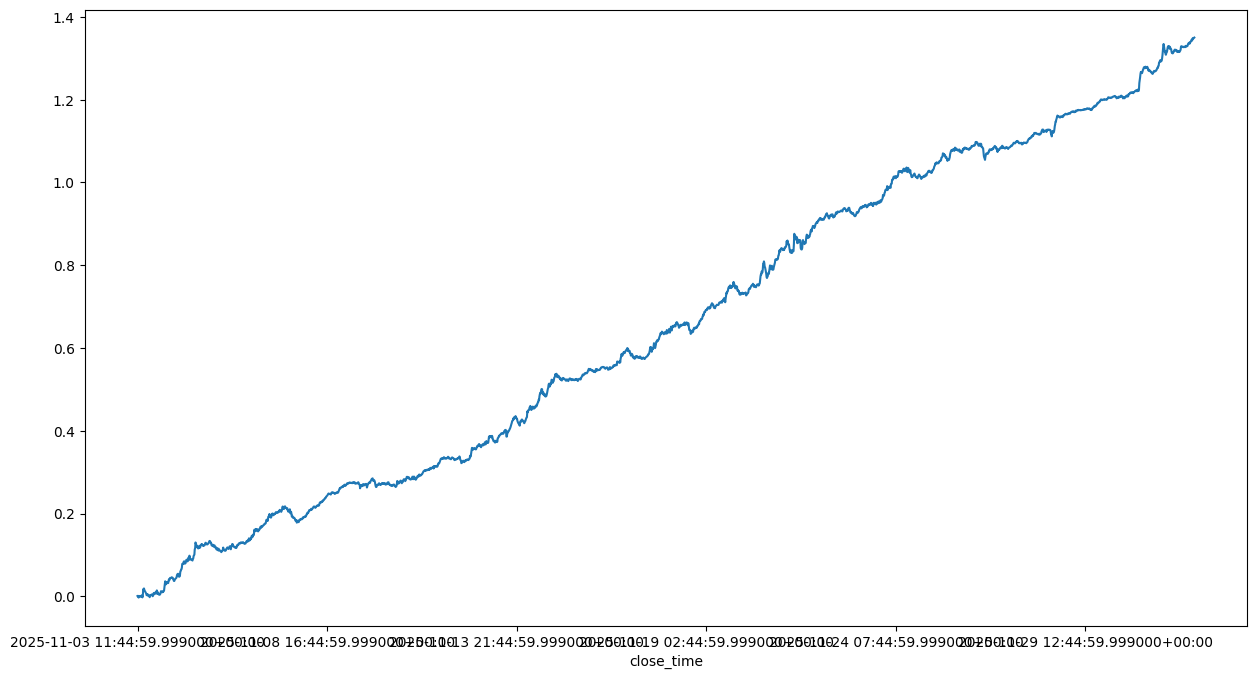

In [105]:
df_test["cum_trade_log_return"].plot(figsize=(15, 8))

<Axes: xlabel='close_time'>

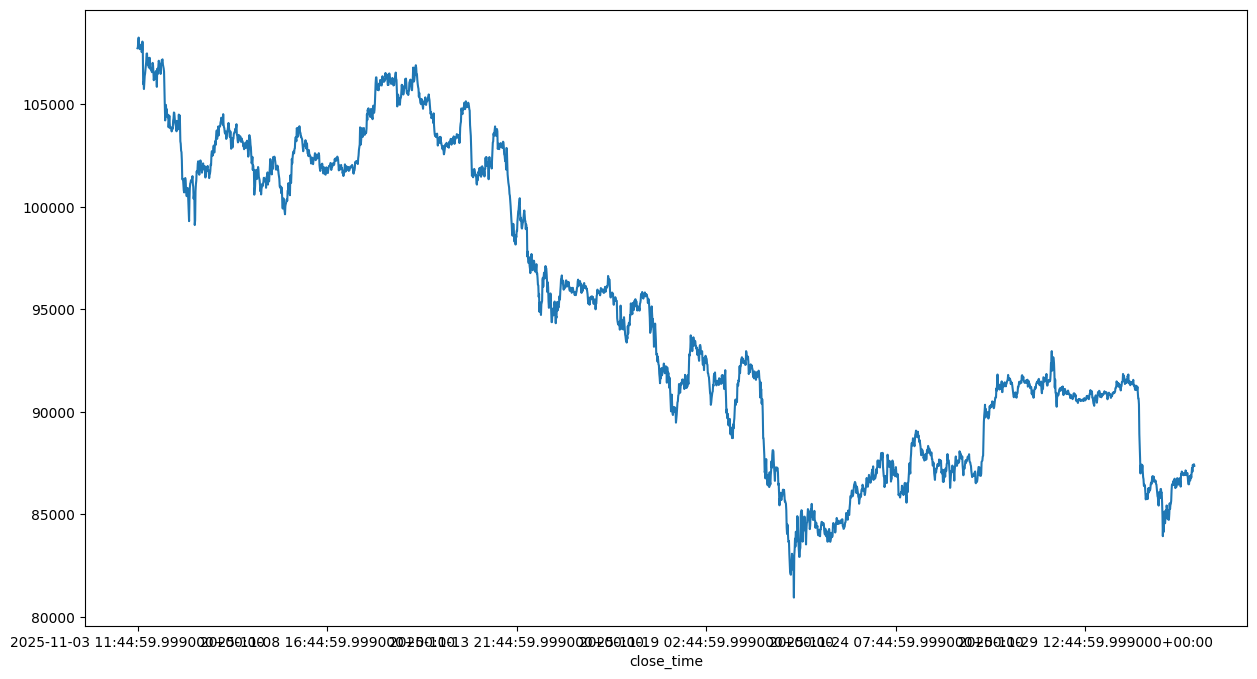

In [106]:
df_test["close"].plot(figsize=(15, 8))

#### Display Equity curve

In [107]:
intial_capital = 100

<Axes: xlabel='close_time'>

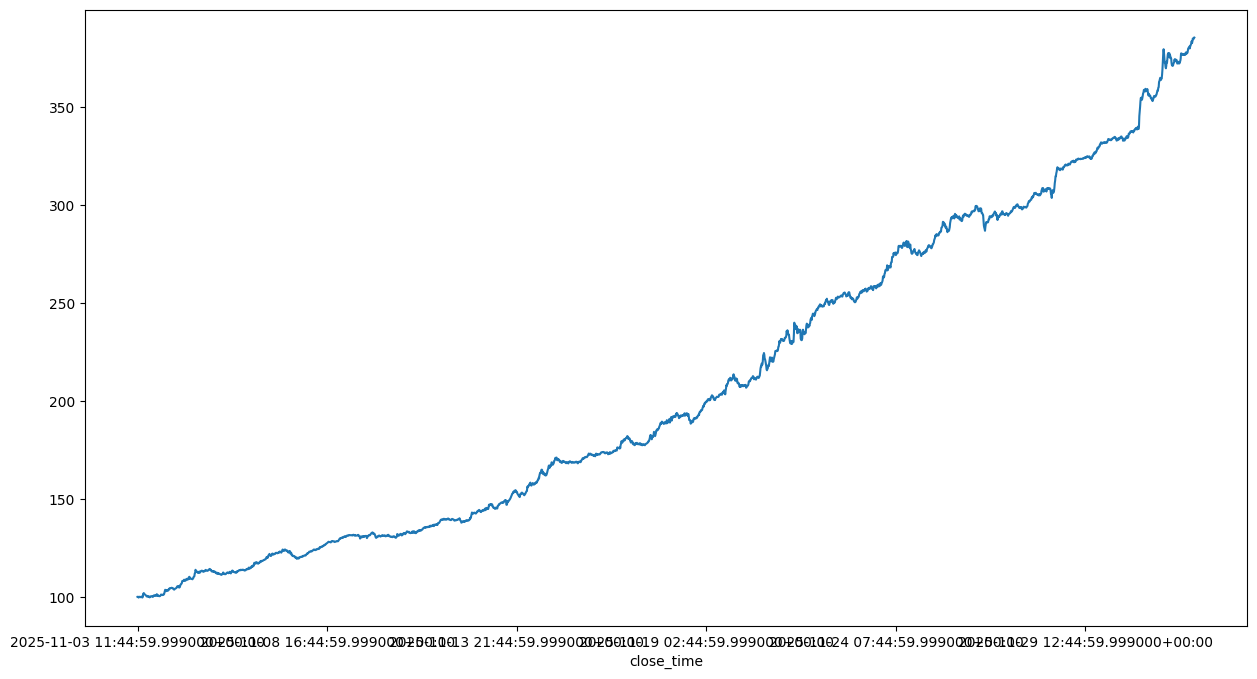

In [108]:
df_test["trade_gross_pnl"] = np.exp(df_test["cum_trade_log_return"]) * intial_capital
df_test["trade_gross_pnl"].plot(figsize=(15, 8))

#### Evaluate total compound return

In [109]:
total_compound_return = np.exp(df_test["trade_log_return"].sum())
total_compound_return

np.float64(3.8568372511401265)

#### Evaluate Gross PnL

In [110]:
total_compound_return * intial_capital

np.float64(385.68372511401265)